# Spotify Playlist Generation using Machine Learning

This project explores how to generate personalized playlists using machine learning based on both musical features (e.g., tempo, energy) and lyrical content. We use two datasets: one with Spotify audio features and another with song lyrics. Two different models are trained — one on music features (a Dense Neural Network), and another to analyze lyrical mood using TF-IDF + clustering.


####UTEP CS 5361 Machine Learning

Kevin Guerra
Kevin Porras

Dr. Fuentes


#Datasets Used:
Lyrical dataset: https://www.kaggle.com/datasets/joebeachcapital/57651-spotify-songs

Song dataset: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

## Import Libraries and Upload Data

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import distutils
import matplotlib.pyplot as plt
import joblib
import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix,mean_squared_error,mean_absolute_error
from google.colab import files
from io import StringIO
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tabulate import tabulate

In [ ]:
# Dictionary to store feedback
# Format: {song_index: feedback_score}
feedback_log = {}

## 1. Load Datasets

We load two primary datasets:
- 30K Spotify songs with audio features
- 60K Spotify songs with lyrics

We inspect the contents and identify the features we'll work with.


In [ ]:
from google.colab import files
uploaded_music = files.upload()
uploaded_lyrics = files.upload()

music_df = pd.read_csv(next(iter(uploaded_music)))
lyrics_df = pd.read_csv(next(iter(uploaded_lyrics)))

Saving music.csv to music.csv


Saving lyrics.csv to lyrics.csv


## 2. Clean and Filter Audio Feature Dataset

We select a subset of relevant audio features from the Spotify songs dataset. This will serve as input to our machine learning models.


In [ ]:
music_keep = ['track_name', 'track_artist', 'danceability', 'energy', 'key', 'loudness',
              'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
              'valence', 'tempo', 'duration_ms']
music_df = music_df[music_keep]

## 3. Process Lyrics and Cluster by Mood

Since the lyrics dataset has no explicit mood labels, we use TF-IDF vectorization followed by KMeans clustering to group songs into `lyrical moods`. These will later help us filter playlist recommendations based on text similarity.


In [ ]:
lyrics_df['text'] = lyrics_df['text'].fillna('')
lyrics_df = lyrics_df[lyrics_df['text'].str.len() > 30]
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(lyrics_df['text'])
kmeans = KMeans(n_clusters=5, random_state=42)
lyrics_df['lyric_cluster'] = kmeans.fit_predict(tfidf_matrix)

## 4. Merge Lyrics with Music Features

We merge both datasets on lowercase track name and artist. Songs with matching names will inherit the `lyric_cluster` label for use in joint analysis. We selected key audio features like Danceability, Energy, and Acousticness as predictors because they best reflect a song’s musical characteristics that influence listener preference. The target variables include measurable traits like Popularity, Valence, and Tempo, which help define a song’s overall feel. Non-musical metadata such as album name and release date were excluded to avoid biased, album-based recommendations.


In [ ]:
lyrics_df['song_lower'] = lyrics_df['song'].str.lower()
lyrics_df['artist_lower'] = lyrics_df['artist'].str.lower()
music_df['track_name_lower'] = music_df['track_name'].str.lower()
music_df['track_artist_lower'] = music_df['track_artist'].str.lower()
merged_df = pd.merge(
    music_df,
    lyrics_df[['song_lower', 'artist_lower', 'lyric_cluster']],
    left_on=['track_name_lower', 'track_artist_lower'],
    right_on=['song_lower', 'artist_lower'],
    how='left')
merged_df['lyric_cluster'] = merged_df['lyric_cluster'].fillna(-1).astype(int)

In [ ]:
# Prepare Train/Test Sets with Aligned DataFrames

def prepare_train_test_sets(df, x_cols, y_cols, test_size=0.8, random_state=0):
    """
    Splits data into X_train, X_test, y_train, y_test and aligned df_train, df_test.
    Returns all 6 outputs for safe playlist generation and modeling.
    """
    X = df[x_cols]
    y = df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    df_train = df.loc[X_train.index]
    df_test = df.loc[X_test.index]
    return X_train, X_test, y_train, y_test, df_train, df_test

# Feature lists
x_name = ['danceability', 'energy', 'loudness', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness',
          'duration_ms', 'lyric_cluster']
y_name = ['key', 'mode', 'valence', 'tempo']

# Use helper to split data and align DataFrames
X_train, X_test, y_train, y_test, df_train, df_test = prepare_train_test_sets(
    merged_df, x_name, y_name, test_size=0.8, random_state=0
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## K-Nearest Neighbor

We selected K-Nearest Neighbors Regression (KNN) because it is a non-parametric, instance-based learning algorithm that makes predictions based on the proximity of training samples to new data points.


Elapsed_time testing  0.133100 
mean_absolute_error: 6.3966
mean_squared_error: 215.432013
key -> MAE: 3.1433, MSE: 15.2918


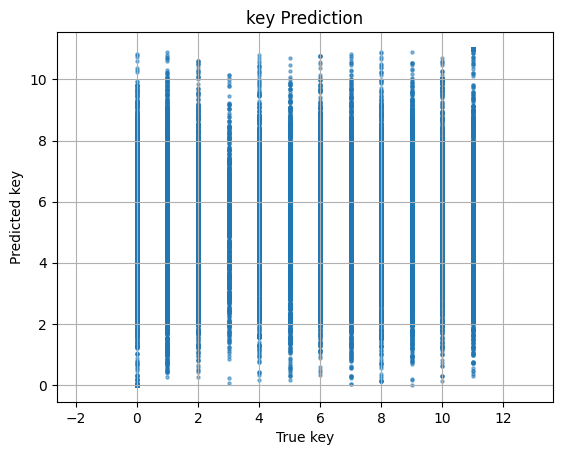

mode -> MAE: 0.4492, MSE: 0.2898


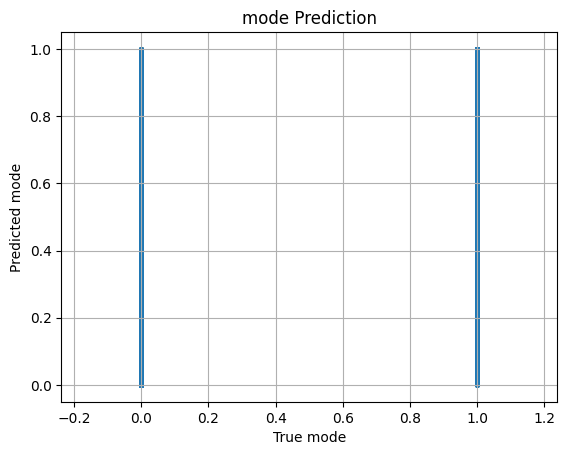

valence -> MAE: 0.1973, MSE: 0.0633


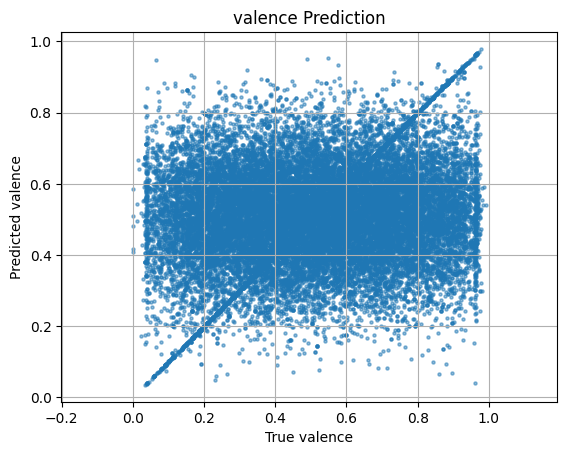

tempo -> MAE: 21.7964, MSE: 846.0831


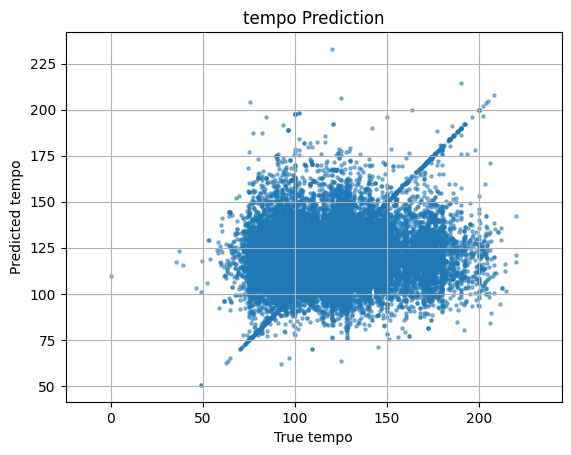

In [ ]:
knn = KNeighborsRegressor(n_neighbors=8, weights='distance')
knn.fit(X_train, y_train)

start = time.time()
pred = knn.predict(X_test)
elapsed_time = time.time()-start
print('\nElapsed_time testing  {0:.6f} '.format(elapsed_time))
print(f'mean_absolute_error: {mean_absolute_error(y_test,pred):6.4f}')

print(f'mean_squared_error: {mean_squared_error(y_test,pred):8.6f}')
# More detailed evaluation per target
target_names = y_name  # ['key', 'mode', 'valence', 'tempo']

for i, name in enumerate(target_names):
    mae = mean_absolute_error(y_test.iloc[:, i], pred[:, i])
    mse = mean_squared_error(y_test.iloc[:, i], pred[:, i])
    print(f"{name} -> MAE: {mae:.4f}, MSE: {mse:.4f}")

    plt.figure()
    plt.scatter(y_test.iloc[:, i], pred[:, i], s=5, alpha=0.5)
    plt.xlabel(f"True {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name} Prediction")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


In [ ]:
distances, indices = knn.kneighbors(X_test)

## 5. Train Dense Neural Network on Music Features

Using the merged dataset, we train a dense neural network that takes musical features and outputs properties like tempo, key, mode, and valence.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Normalize input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # 4 outputs for key, mode, valence, tempo
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3506.4016 - mae: 30.2248 - val_loss: 1286.1996 - val_mae: 17.3480
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 693.7936 - mae: 11.8818 - val_loss: 294.4204 - val_mae: 7.5066
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 262.5633 - mae: 7.1099 - val_loss: 255.0013 - val_mae: 7.0491
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 227.6884 - mae: 6.7271 - val_loss: 235.9891 - val_mae: 6.7985
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 217.7166 - mae: 6.5577 - val_loss: 223.5557 - val_mae: 6.6646
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 206.3053 - mae: 6.4427 - val_loss: 215.3277 - val_mae: 6.5499
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 205.9555 - mae: 6.4268 - val_loss: 209.2931 - val_mae: 6.4787
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 196.3365 - mae: 6.2539 - val_loss: 205.0755 - val_mae: 6.4264
Epoch 9/50
165/165 ━━━━━━━━━━━

821/821 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
key -> MAE: 3.1674, MSE: 13.2217


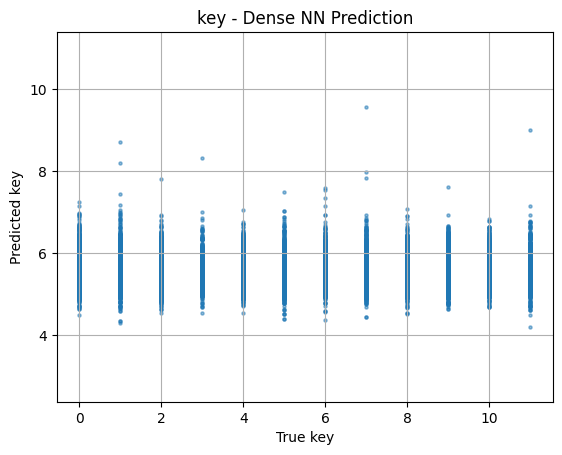

mode -> MAE: 0.4709, MSE: 0.2675


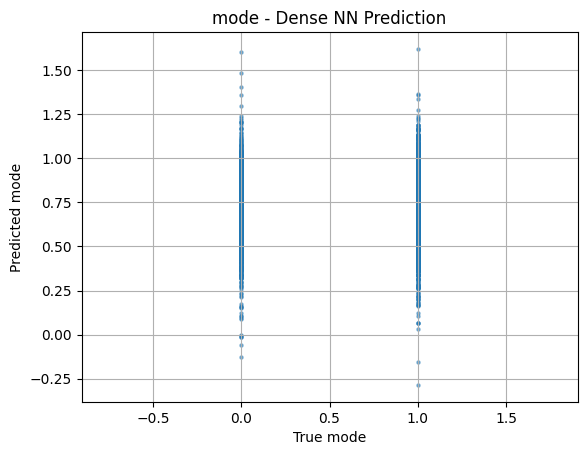

valence -> MAE: 0.1803, MSE: 0.0496


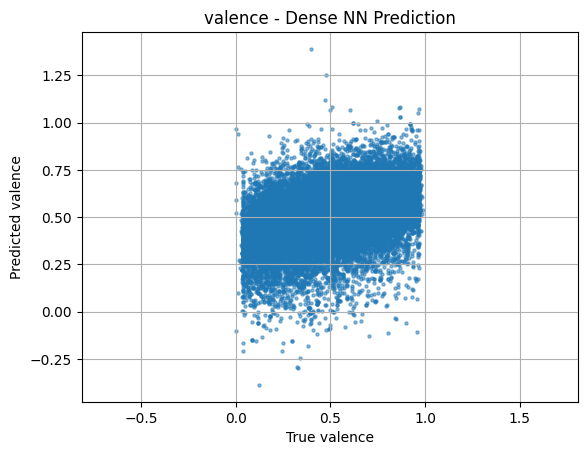

tempo -> MAE: 20.3164, MSE: 687.9318


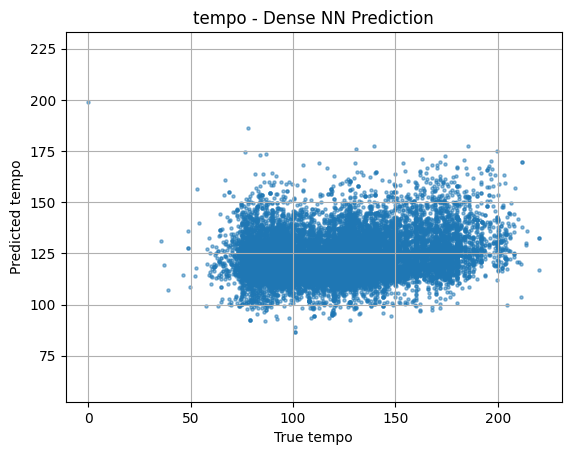

In [ ]:
# Convert y_test to NumPy for clean slicing
y_test_np = y_test.to_numpy()

# Predict on test set
pred_nn = model.predict(X_test_scaled)

# Evaluate per output
for i, name in enumerate(y_name):
    mae = mean_absolute_error(y_test_np[:, i], pred_nn[:, i])
    mse = mean_squared_error(y_test_np[:, i], pred_nn[:, i])
    print(f"{name} -> MAE: {mae:.4f}, MSE: {mse:.4f}")

    # Plot predicted vs true values
    plt.figure()
    plt.scatter(y_test_np[:, i], pred_nn[:, i], s=5, alpha=0.5)
    plt.xlabel(f"True {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name} - Dense NN Prediction")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


## 6. Evaluate Neural Network and Compare with KNN

We compare the model performance between a Dense Neural Network and a K-Nearest Neighbors regressor using MAE and MSE across predicted features.


In [ ]:
X_test_scaled = scaler.transform(X_test)
pred_nn = model.predict(X_test_scaled)


821/821 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
print(len(y_test), len(pred), len(pred_nn))


26270 26270 26270


In [ ]:
from tabulate import tabulate

print("📊 Comparison of KNN vs Dense NN (MAE & MSE)\n")

rows = []
for i, name in enumerate(y_name):
    knn_mae = mean_absolute_error(y_test.iloc[:, i], pred[:, i])
    knn_mse = mean_squared_error(y_test.iloc[:, i], pred[:, i])

    nn_mae = mean_absolute_error(y_test.iloc[:, i], pred_nn[:, i])
    nn_mse = mean_squared_error(y_test.iloc[:, i], pred_nn[:, i])

    rows.append([name, f"{knn_mae:.4f}", f"{nn_mae:.4f}", f"{knn_mse:.4f}", f"{nn_mse:.4f}"])

print(tabulate(rows, headers=["Target", "KNN MAE", "NN MAE", "KNN MSE", "NN MSE"]))


📊 Comparison of KNN vs Dense NN (MAE & MSE)

Target      KNN MAE    NN MAE    KNN MSE    NN MSE
--------  ---------  --------  ---------  --------
key          3.1433    3.1674    15.2918   13.2217
mode         0.4492    0.4709     0.2898    0.2675
valence      0.1973    0.1803     0.0633    0.0496
tempo       21.7964   20.3164   846.083   687.932


## 7. Generate Playlist Recommendations

Given a selected song, we generate a playlist of similar tracks based on:
- Proximity in predicted audio feature space
- Shared lyrical mood (`lyric_cluster`)


In [ ]:
def retrain_model_with_feedback(model, X_train, y_train, scaler, feedback_log, original_df, epochs=50):
    """
    Retrains the model using sample weights derived from user feedback.

    Parameters:
    - model: compiled Keras model
    - X_train: DataFrame of training features (unscaled)
    - y_train: ndarray of training targets
    - scaler: fitted StandardScaler object
    - feedback_log: dict of {index: rating}
    - original_df: full DataFrame used for indexing (e.g., merged_df)
    - epochs: number of training epochs
    """

    print("\n🔁 Rebuilding sample weights from feedback...")

    # Initialize all weights to 1.0
    sample_weights = np.ones(len(X_train))

    # Update weights for rated samples
    for global_idx, rating in feedback_log.items():
        if global_idx in X_train.index:
            local_idx = X_train.index.get_loc(global_idx)
            # Weight: neutral = 1.0, liked = >1, disliked = <1
            sample_weights[local_idx] = 1 + 0.2 * (rating - 3)

    # Optional: normalize weights to avoid instability
    sample_weights = np.clip(sample_weights, 0.5, 2.0)

    # Scale features again
    X_train_scaled = scaler.transform(X_train)

    print("🧠 Retraining model with feedback-based weights...")
    history = model.fit(
        X_train_scaled, y_train,
        sample_weight=sample_weights,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    print("✅ Retraining complete.")
    return history


In [ ]:
def adjust_distances_with_feedback(distances, indices, feedback_log, boost_factor=0.8):
    adjusted = distances.copy()
    for i in indices:
        if i in feedback_log:
            rating = feedback_log[i]
            adjusted[i] *= (1 - (rating - 3) * 0.1 * boost_factor)  # higher rating = smaller distance
    return adjusted


In [ ]:
def generate_playlist(index, model, X_source, df, scaler, feedback_log, n_recs=5):
    # Make sure X_source is a DataFrame
    x_input = scaler.transform([X_source.iloc[index]]) if hasattr(X_source, 'iloc') else scaler.transform([X_source[index]])

    input_song = df.iloc[index]
    print(f"\n🎵 Input Song: {input_song['track_name']} — {input_song['track_artist']}")

    # Predict for the input
    y_pred = model.predict(x_input)[0]

    # Predict all and compute distances
    X_scaled = scaler.transform(X_source) if hasattr(X_source, 'iloc') else scaler.transform(X_source)
    y_all_pred = model.predict(X_scaled)
    distances = euclidean_distances([y_pred], y_all_pred).flatten()

    # Filter by same lyric mood
    df_filtered = df.loc[X_source.index]
    same_cluster = df_filtered['lyric_cluster'] == input_song['lyric_cluster']
    distances[~same_cluster] = float('inf')

    # Get closest matches
    similar_indices = distances.argsort()[1:n_recs+1]

    print("\n🎧 Recommended Playlist (same lyrical mood):")
    for i in similar_indices:
        song = df.iloc[i]
        print(f"{i}. {song['track_name']} — {song['track_artist']}")

    print("\n📝 Please rate the recommended songs (1–5):")
    for i in similar_indices:
        song = df.iloc[i]
        try:
            rating = int(input(f"Rate {song['track_name']} by {song['track_artist']}: "))
        except:
            rating = 3
        feedback_log[i] = rating


In [ ]:
# Run the function with proper parameters
generate_playlist(
    index=10,
    model=model,
    X_source=X_test,
    df=merged_df,
    scaler=scaler,
    feedback_log=feedback_log,
    n_recs=5
)



🎵 Input Song: Cross Me (feat. Chance the Rapper & PnB Rock) - M-22 Remix — Ed Sheeran
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

🎧 Recommended Playlist (same lyrical mood):
20905. Confío — Gui Brazil
25133. Stone Cold Gentleman — Ralph Tresvant
16402. Años Luz — Romeo Santos
20616. Touch Me - All Night Long — Wish & Fonda Rae
5006. Pray — The Erised

📝 Please rate the recommended songs (1–5):
Rate Confío by Gui Brazil: 1
Rate Stone Cold Gentleman by Ralph Tresvant: 2
Rate Años Luz by Romeo Santos: 3
Rate Touch Me - All Night Long by Wish & Fonda Rae: 1
Rate Pray by The Erised: 2


In [ ]:
print("📊 Feedback Summary:")
for i, rating in feedback_log.items():
    song = merged_df.iloc[i]
    print(f"{song['track_name']} — {song['track_artist']} : {rating}/5")


📊 Feedback Summary:
Confío — Gui Brazil : 1/5
Stone Cold Gentleman — Ralph Tresvant : 2/5
Años Luz — Romeo Santos : 3/5
Touch Me - All Night Long — Wish & Fonda Rae : 1/5
Pray — The Erised : 2/5


### Division of Work
Kevin Guerra score = 50%
Kevin Porras score = 50%

Kevin Guerra contributions:

Iniitially, we both brainstormed a more refine idea together stemming from my idea of making something similar to spotify.
To start, I found the music dataset and the lyric dataset on Kaggle and sent them to Porras to evaluate.
After I focused heavily on handing our data upon upload.
Together, we decided what values to use to predict and to be precicted from the music dataset.
I suggested first we try out a K-Nearest Neighbor so I focused more on the aspect including how many neighbors to use.


Kevin Porras contributions:

I started off by polishing Guerra's initial idea and giving us more direction in what to do.
Then, after the data was well handled and uploaded, I moved on to splitting into X and y for the musical dataset, togehter with Guerra, we decided which values should be used to predict and which should be predicted.
I suggested we run a Dense Nueral Network and as such I focused more on this aspect of the code.